#run this way of training
#try to penalize lack of smoothness somehow
#tru KL div as cost function (remove the *256 when creatinng histograms y)

In [1]:
!pip install fast-histogram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 209 kB/s 


In [2]:
import torch
import torch.nn as nn
import numpy as np
import torchvision as T
import tqdm
import matplotlib.pyplot as plt

from fast_histogram import histogram1d

In [3]:
nb_images = 5000
batch_size = 25
img_size = 256*256

In [4]:
def torch_gaussian_image(mean,variance):
  img = (torch.randn(256*256)*variance)+mean
  #img += torch.rand(256*256)*(torch.numel(img)/10)
  img = img.reshape((1,256,256))
  return img

In [298]:
means = 50
variance = 30
minibatches_X = [torch.stack([torch_gaussian_image(np.random.randint(0,256),np.random.randint(2,60))/2.+torch_gaussian_image(np.random.randint(0,256),np.random.randint(2,60))/2. for i in range(batch_size)]) for l in range(0,nb_images,batch_size)]
minibatches_y = [256.*torch.stack([torch.Tensor(histogram1d(image.flatten(),bins=256,range=[0,256]))/img_size for image in batch]) for batch in minibatches_X]

minibatches_X = [batch.to("cuda:0") for batch in minibatches_X]
minibatches_y = [batch.to("cuda:0") for batch in minibatches_y]

In [259]:
minibatches_X[0].shape

torch.Size([25, 1, 256, 256])

In [270]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 =  nn.Conv2d(1,10,3,2)
    
    self.conv2 =  nn.Conv2d(10,10,3,2)

    self.conv3 =  nn.Conv2d(10,1,3,2)

    self.fl = nn.Flatten()
    self.lin = nn.Linear(31*31*1,256)

  def forward(self,x):
    x = self.conv1(x)
    x = nn.functional.relu(x)

    x = self.conv2(x)
    x = nn.functional.relu(x)

    x = self.conv3(x)
    x = nn.functional.relu(x)

    x = self.fl(x)


    x = self.lin(x)
    x = nn.ReLU()(x)
    return x

In [282]:
def create_the_model():
  model = Model().to("cuda:0")
  loss = nn.L1Loss()
  opt = torch.optim.Adam(model.parameters(),lr=0.0001)
  return model,loss,opt

In [283]:
model,loss,opt = create_the_model()

model(minibatches_X[0]).shape

torch.Size([25, 256])

In [284]:
def plot_comparisons(model,pred,histograms):
  plt.figure(figsize=(len(pred)*10,10))
  for i in range(len(pred)):
    plt.subplot(2,len(pred),i+1)
    plt.plot(pred[i].cpu().detach())
    plt.title("prediction")
    plt.subplot(2,len(pred),len(pred)+1+i)
    plt.plot(histograms[i].cpu().detach())
    plt.title("real")
  plt.show()

In [293]:
def train_the_model(nb_epochs):
  losses = []
  epoch_losses=[]

  lrs = list(opt.param_groups[0]['lr']*torch.log(torch.linspace(10,1,nb_epochs))/np.log(10) +opt.param_groups[0]['lr']/20.)
  i=0
  while i<nb_epochs:# or np.mean(losses[-300:])>losses[-1]:#stop only when loss didn't improve overall in the last 10 iterations
    i+=1
    for (X,y) in zip(minibatches_X,minibatches_y):


      pred = model(X)


      l = loss(pred,y)
    

      if i<nb_epochs:
        opt.param_groups[0]['lr'] = lrs[i]
      else:
        opt.param_groups[0]['lr'] *= 0.9
        lrs.append(opt.param_groups[0]['lr'])

      opt.zero_grad()
      l.backward()
      opt.step()

      losses.append(l.item())
    epoch_losses.append(np.mean(losses[-100:]))
    print("\nepoch",i,"loss improved by",np.mean(losses[-100:])-losses[-1])
  plot_comparisons(model,pred[:10],y[:10])
  plt.title("learning rates (up to 100 first epochs)")
  plt.plot(lrs[:100])
  plt.show()
  return epoch_losses


epoch 1 loss improved by 0.009691821336746176

epoch 2 loss improved by 0.011199969053268477

epoch 3 loss improved by 0.011413745880127002

epoch 4 loss improved by 0.012877753973007167

epoch 5 loss improved by 0.01211090803146364

epoch 6 loss improved by 0.013165934085845987

epoch 7 loss improved by 0.015431514382362344

epoch 8 loss improved by 0.01560196399688718

epoch 9 loss improved by 0.016233527660369895

epoch 10 loss improved by 0.018376620411872824

epoch 11 loss improved by 0.018228034973144513

epoch 12 loss improved by 0.01892651498317721

epoch 13 loss improved by 0.017392616868019073

epoch 14 loss improved by 0.01780232369899748

epoch 15 loss improved by 0.017470033168792698

epoch 16 loss improved by 0.01722221851348882

epoch 17 loss improved by 0.018291661739349374

epoch 18 loss improved by 0.017596014142036487

epoch 19 loss improved by 0.018822243213653556

epoch 20 loss improved by 0.017698121070861772

epoch 21 loss improved by 0.01909016251564022

epoch 

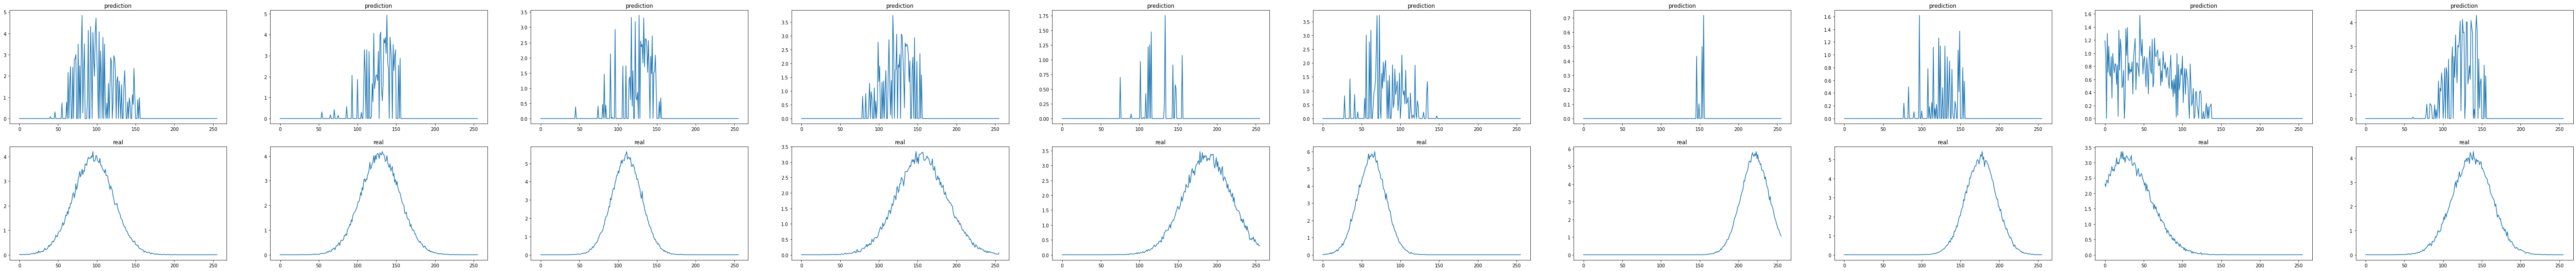

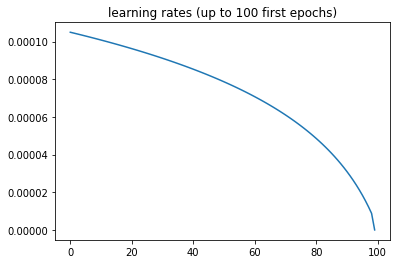

Text(0.5, 1.0, 'losses')

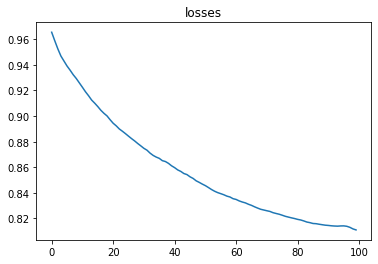

In [299]:
model,loss,opt = create_the_model()

losses = train_the_model(100)
plt.plot(losses)
plt.title("losses")

In [296]:
print(np.sqrt(losses[-5:]))

[0.81381912 0.81410031 0.81396395 0.81358149 0.81426562]
